# Analyse von Hunderassen und ihren Gesundheitsproblemen

Dieses Notebook analysiert Daten über Hunderassen, um zu verstehen, welches Hauptmerkmal am stärksten mit häufigen Gesundheitsproblemen korreliert.

In [38]:
# Importieren der benötigten Bibliotheken
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import re
import sqlite3
from kaggle.api.kaggle_api_extended import KaggleApi

In [39]:
# Kaggle-API-Konfiguration und Datenladen
api = KaggleApi()
api.authenticate()
api.dataset_download_files("marshuu/dog-breeds", unzip=True, path='../data')
df = pd.read_csv('../data/dog_breeds.csv')

In [40]:
## Datenbereinigung und Vorbereitung
# Umwandlung von 'Height (in)' und 'Longevity (yrs)' in numerische Werte mittels regulärer Ausdrücke
def extract_numeric_average(text):
    numbers = re.findall(r'\d+\.?\d*', text)
    numbers = [float(num) for num in numbers]
    return sum(numbers) / len(numbers) if numbers else None

df['Height (in)'] = df['Height (in)'].apply(extract_numeric_average)
df['Longevity (yrs)'] = df['Longevity (yrs)'].apply(extract_numeric_average)

# 'Character Traits' 'Common Health Problems' in separate Probleme, konvertiert zu Kleinbuchstaben
df['Common Health Problems'] = df['Common Health Problems'].str.lower()
df['Character Traits'] = df['Character Traits'].str.lower()

In [41]:
# Speichern der bereinigten Daten in einer SQLite-Datenbank
conn = sqlite3.connect('../data/dog_breeds.db')
try:
    df.to_sql('cleaned_data', conn, if_exists='replace', index=False)
finally:
    conn.close()

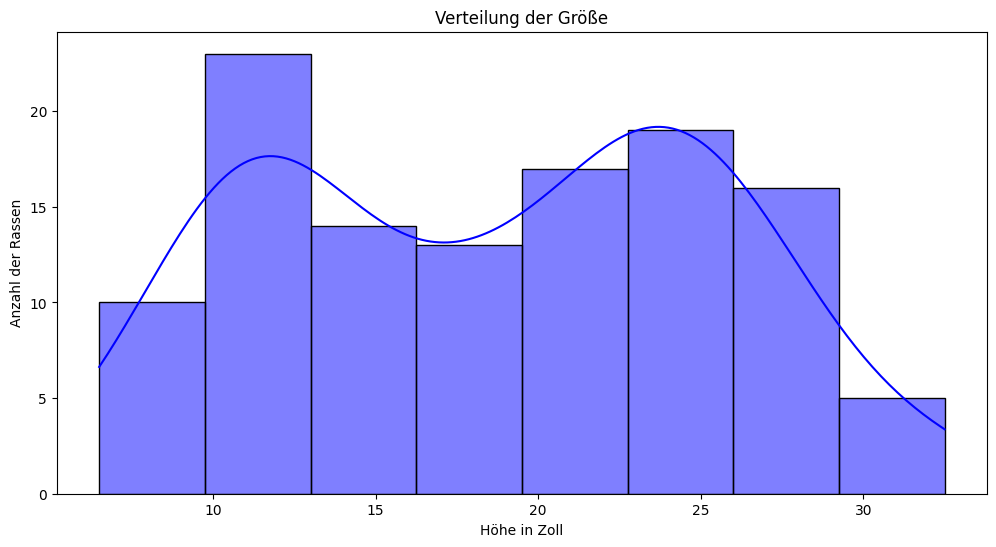

In [42]:
## Explorative Datenanalyse (EDA)
# Statistische Übersicht
stat_summary = df.describe()

# Visualisierungen der Verteilungen
plt.figure(figsize=(12, 6))
sns.histplot(df['Height (in)'], kde=True, color='blue')
plt.title('Verteilung der Größe')
plt.xlabel('Höhe in Zoll')
plt.ylabel('Anzahl der Rassen')
plt.show()

In [43]:
## Statistische Analyse
# Extraktion nur der numerischen Spalten für die Korrelationsanalyse
numeric_cols = df.select_dtypes(include=[np.number])  # Wählt nur numerische Spalten

# Korrelationsanalyse
correlation_matrix = numeric_cols.corr()

# Statistische Tests zur Bestimmung von p-Werten
def calculate_p_values(df):
    df = df.dropna()._get_numeric_data()
    cols = df.columns
    pvals = pd.DataFrame(columns=cols, index=cols)
    for r in cols:
        for c in cols:
            if r != c:  # Vermeidung der Korrelation einer Spalte mit sich selbst
                pvals[r][c] = pearsonr(df[r], df[c])[1]
            else:
                pvals[r][c] = np.nan  # Setzt die Diagonale auf NaN, da die Korrelation mit sich selbst nicht sinnvoll ist
    return pvals

p_values = calculate_p_values(numeric_cols)

## Ergebnisse
# Anzeige der Korrelationsmatrix und der p-Werte
print("Korrelationsmatrix der numerischen Variablen:")
print(correlation_matrix)
print("\nP-Werte der Korrelationen:")
print(p_values)



Korrelationsmatrix der numerischen Variablen:
                 Height (in)  Longevity (yrs)
Height (in)         1.000000        -0.618273
Longevity (yrs)    -0.618273         1.000000

P-Werte der Korrelationen:
                Height (in) Longevity (yrs)
Height (in)             NaN             0.0
Longevity (yrs)         0.0             NaN


/var/folders/kg/d8s6hml15gl3z665tpnpfj0h0000gn/T/ipykernel_25195/1398631770.py:18: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  pvals[r][c] = np.nan  # Setzt die Diagonale auf NaN, da die Korrelation mit sich selbst nicht sinnvoll ist
/var/